# D213 - Advanced Data Analytics Performance Assessment Task 1

Assignment Completed by Favio Conde and Submitted August 21, 2023 for WGU - MSDA
</br>

### Table of Contents

#### Part I: Research Question
<ul>
    <li><a href='#a1'>A1: Research Question</a></li>
    <li><a href='#a2'>A2: Objectives or Goals</a></li>
</ul>
 
#### Part II: Method Justification
<ul>
    <li><a href='#b'>B. Summary of Assumptions</a></li>
</ul> 

#### Part III: Data Preparation
<ul>
    <li><a href='#c1'>C1: Line Graph Visualization</a></li>
    <li><a href='#c2'>C2: Time Step Formatting</a></li>
    <li><a href='#c3'>C3: Stationarity</a></li>
    <li><a href='#c4'>C4: Steps to Prepare the Data</a></li>
    <li><a href='#c5'>C5: Prepared Data Set</a></li>
</ul>

#### Part IV: Model Identification and Analysis
<ul>
    <li><a href='#d1'>D1: Report Findings and Visualizations</a></li>
    <li><a href='#d2'>D2: ARIMA Model</a></li>
    <li><a href='#d3'>D3: Forecasting Using ARIMA Model</a></li>
    <li><a href='#d4'>D4: Output and Calculations</a></li>
    <li><a href='#d5'>D5: Code</a></li>
</ul>

#### Part V: Data Summary and Implications
<ul>
    <li><a href='#e1'>E1: Results</a></li>
    <li><a href='#e2'>E2. Annotated Visualization</a></li>
    <li><a href='#e3'>E3. Recommendation</a></li>
</ul>

#### Part VI: Reporting
<ul>
    <li><a href='#f'>F: Reporting</a></li>
    <li><a href='#g'>G. Third-Party Code Reference</a></li>
    <li><a href='#h'>H. Sources</a></li>
</ul>

### PART I: RESEARCH QUESTION

#### A1. Research Question<a id='a1'></a>

Can the daily revenues be accurately predicted using an ARIMA model?

#### A2. Objectives or Goals<a id='a2'></a>

My analysis aims to determine if an ARIMA time series model can be used to predict the hospital's daily revenue. To employ the technique, I will split the data into a training and testing set and determine if the model can accurately predict the daily revenue in the testing set.

### PART II: METHOD JUSTIFICATION

#### B. Summary of Assumptions<a id='b'></a>

The ARIMA model has several assumptions:

<ul>
    <li>Past behavior indicate future performance</li>
    <li>The dataset does not contain any anomalies or outliers</li>
    <li>Model parameters and error terms are constant</li>
    <li>The dataset is stationary</li>
</ul>

Time series models aim to predict future outcomes by analyzing historical data.  This analysis method assumes that that future trends will be similar to past trends, and that there are no anomalies that exist in the dataset since outliers could affect the analysis.  Another model assumption is that there is no variance in the model parameters or error terms.

The ARIMA model assumes that the time series data is stationary, which means the mean and variance are consistent over time and that no seasonality exists in the data, implying no trends are present (Rajbhoj, 2019).  Auto-correlated data considers both direct and indirect effects.  In Rajbhoj's article in Towards Data Science, he uses the example of Saturday affecting Sunday's gas price (direct) and Friday's gas price affecting Saturday's, ultimately impacting Sunday's gas price (indirect).  Auto-correlation considers the similarity between a data point and the lagged version of itself over a time interval; it considers how correlated points in the data are today compared to points in the past.

### PART III: DATA PREPARATION

#### C1. Line Graph Visualization<a id='c1'></a>

In [1]:
#import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
#importing CSV
df = pd.read_csv('medical_time_series.csv')
#setting starting date and setting it as the index
df['Date'] = pd.date_range(start=datetime(2020,1,1), periods=df.shape[0], freq='24H')
df.set_index('Date', inplace=True)

In [3]:
#checking dataset dimensions
df.shape

(731, 2)

In [4]:
#checking for null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 17.1 KB


In [5]:
#dropping the Day columns
df = pd.DataFrame(df['Revenue'])

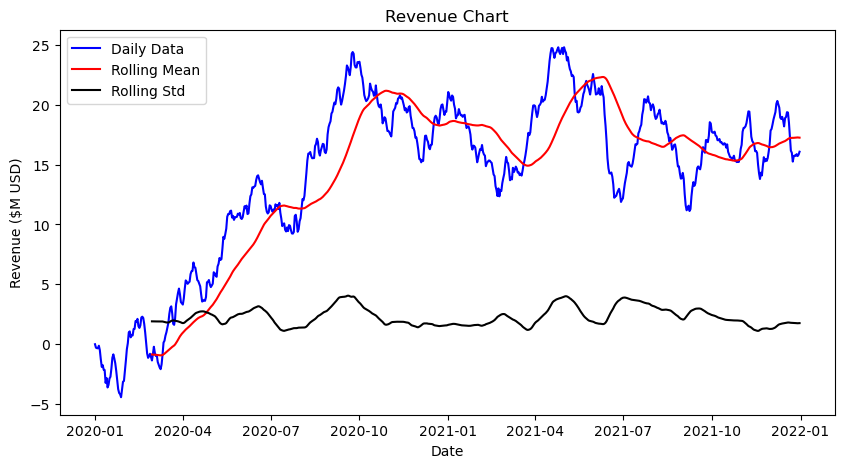

In [6]:
#creating rolling mean and std lines
rolmean = df.rolling(window=60).mean()
rolstd = df.rolling(window=60).std()

#creating line graph
plt.figure(figsize=(10,5))
orig = plt.plot(df['Revenue'],color='blue', label='Daily Data')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel(f'Revenue ($M USD)')
plt.show()

#### C2. Time Step Formatting<a id='c2'></a>

The medical time series data contains daily revenues for 731 days, two years, with one year having 366 days (a leap year).  There was no missing data, so I did not need to impute any values.  In <a href='#c2'>C2</a>, I imported the time series data and added a date in the index to represent each day in the data set.  There were no specifics in the data dictionary pointing at a year, so I started the date as 2020-01-01 since that was the most recent leap year.  As a result, `Day 1` became `2020-01-01` and `Day 731` became `2021-12-31`.  I can now perform date calculations on the data since I converted the index from day to date.

#### C3. Stationarity<a id='c3'></a>

To check for stationarity, I used the ADFuller method.  The following results indicated that there are trends that exist in the time series:

<ul>
    <li>The P-value was greater than 0.05</li>
    <li>The absolute values of the critical values are greater than the ADF value</li>
</ul>

Additionally, a clear trend is visible from the line graph in <a href='#c1'>C1</a>.  Since the line graph increases as the date progresses, the mean and STD are not constant, indicating that the data is not stationary.

In [7]:
#checking the stationarity using the ADFuller method
print('Augmented Dickey-Fuller Test')
print('-'*28)

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-value ', dftest[1])
    print('3. Num of Lags: ', dftest[2])
    print('4. Num of Obs Used for ADF Regression and Critical Value Calc: ', dftest[3])
    print('5. Critical Values: ')
    for key, val in dftest[4].items():
        print('\t', key, ': ', val)
  
ad_test(df)

Augmented Dickey-Fuller Test
----------------------------
1. ADF:  -2.2183190476089454
2. P-value  0.19966400615064356
3. Num of Lags:  1
4. Num of Obs Used for ADF Regression and Critical Value Calc:  729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


#### C4. Steps to Prepare the Data<a id='c4'></a>

To prepare the data for the analysis, I first went through the process described in <a href='#c2'>C2</a> to import the CSV file and convert the days into date format.  In <a href='#c3'>C3</a>, I checked for stationarity and confirmed that trends were present in the data set.

To further prepare the data for the analysis, I needed to make the time series data stationary. To accomplish this goal, I used the `.diff()` function for differencing, called the differenced dataset `df_diff`, plotted to confirm if the data was not stationary, and reran the Augmented Dickey-Fuller test. Based on the line graph and the results of the ADF test, the data is now stationary.

I split my data using the 80/20 rule into a training and testing data set and exported as CSV files, along with the `df_diff` data.

<AxesSubplot:xlabel='Date'>

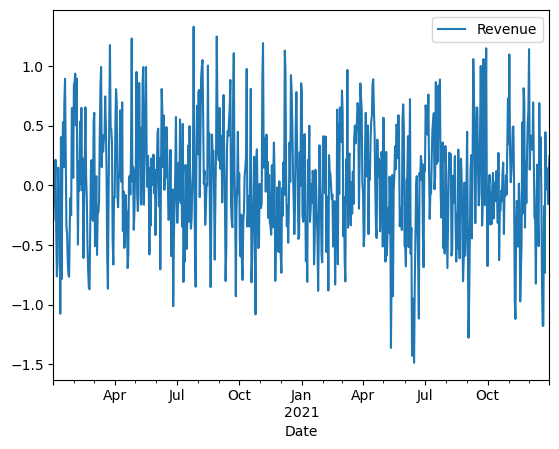

In [8]:
#calculating the diff() to remove trends
df_diff = df.diff().dropna()
df_diff.plot()

In [9]:
#checking the stationarity of df_diff using the ADFuller method
print('Augmented Dickey-Fuller Test')
print('-'*28)

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-value ', dftest[1])
    print('3. Num of Lags: ', dftest[2])
    print('4. Num of Obs Used for ADF Regression and Critical Value Calc: ', dftest[3])
    print('5. Critical Values: ')
    for key, val in dftest[4].items():
        print('\t', key, ': ', val)
  
ad_test(df_diff)

Augmented Dickey-Fuller Test
----------------------------
1. ADF:  -17.374772303557062
2. P-value  5.113206978840171e-30
3. Num of Lags:  0
4. Num of Obs Used for ADF Regression and Critical Value Calc:  729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


In [10]:
#creating test and traing data sets using the 80/20 rule
train, test = train_test_split(df_diff, train_size=0.8, test_size=0.2, random_state=15, shuffle=False)

#checking shapes of each data set
print('Data Dimensions')
print('-'*15)
print(f'The dimensions for the differenced data set is: {df_diff.shape}')
print(f'The dimensions for the training data set is: {train.shape}')
print(f'The dimensions for the testing data set is: {test.shape}')

Data Dimensions
---------------
The dimensions for the differenced data set is: (730, 1)
The dimensions for the training data set is: (584, 1)
The dimensions for the testing data set is: (146, 1)


#### C5. Prepared Data Set<a id='c5'></a>

In [11]:
#exporting all data sets
df_diff.to_csv(r'medical_differenced.csv', index=True)
train.to_csv(r'medical_training.csv', index=True)
test.to_csv(r'medical_testing.csv', index=True)

### PART IV: MODEL IDENTIFICATION AND ANALYSIS

#### D1. Report Findings and Visualizations<a id='d1'></a>

##### Seasonality

I used the seasonal graph from the `seasonal_decompose` method. The graph is repetitive, but it isn't easy to see the data. I plotted the same graph but looked at two months: 2020-01-01 to 2020-02-29. From the zoomed-in seasonality line graph, a seasonality pattern is apparent. The pattern repeats about four times monthly, indicating weekly seasonality, perhaps due to weekday versus weekend sales.

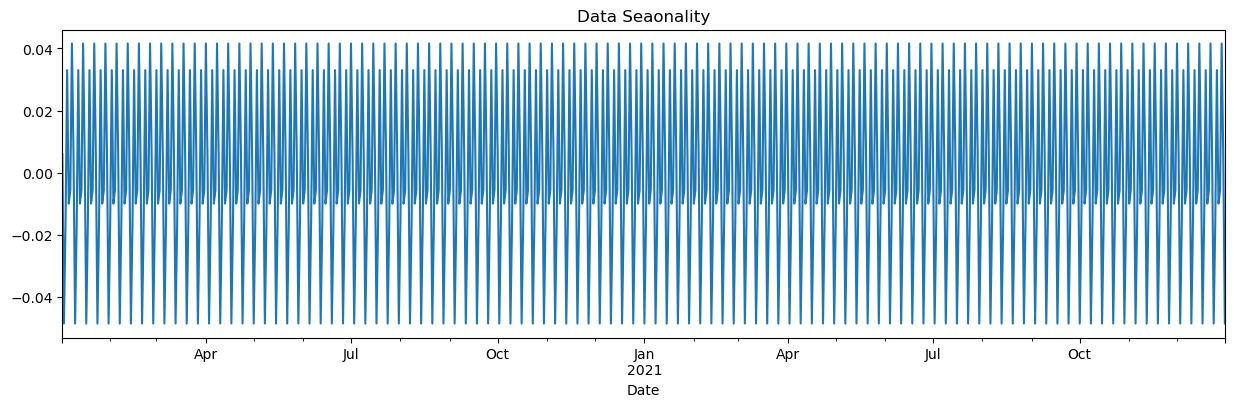

In [12]:
#decomposing data and ploting seasonality graph
df_decomp = seasonal_decompose(df_diff)
plt.figure(figsize=(15,4))
df_decomp.seasonal.plot()
plt.title('Data Seaonality')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

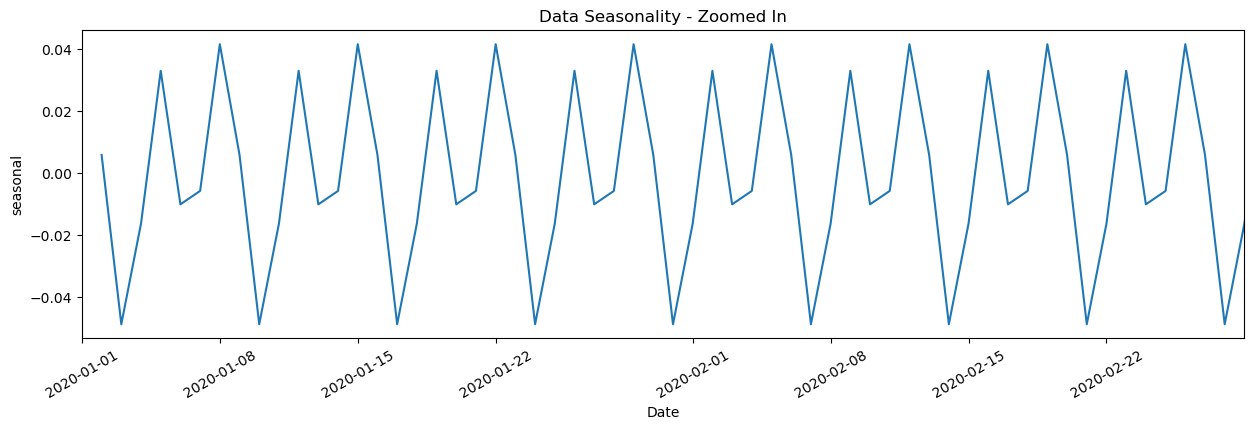

In [13]:
#zooming in to graph
plt.figure(figsize=(15,4))
sns.lineplot(data=df_decomp.seasonal)
plt.title('Data Seasonality - Zoomed In')
plt.xticks(rotation=30)
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-29'))
plt.show

##### Trend

I used the trend graph from the `seasonal_decompose` method. The chart doesn't have any repetition, but I wanted to follow a similar process that I did with seasonality.  I plotted the same graph but looked at two months: 2020-01-01 to 2020-02-29. From the zoomed-in trend line graph, no obvious pattern is apparent. The graph shows that revenues peaked in February 2020, August 2020, and mid-April 2021, but revenue was most negative in June 2021.

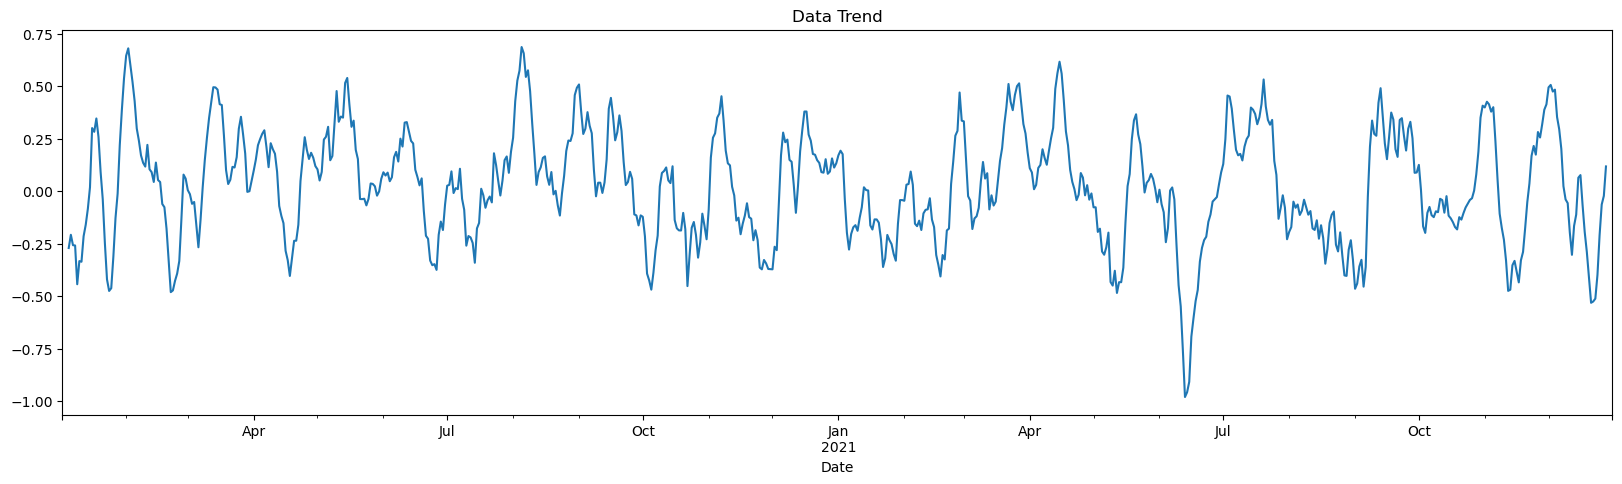

In [14]:
#plotting trend graph
plt.figure(figsize=(20,5))
df_decomp.trend.plot()
plt.title('Data Trend')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

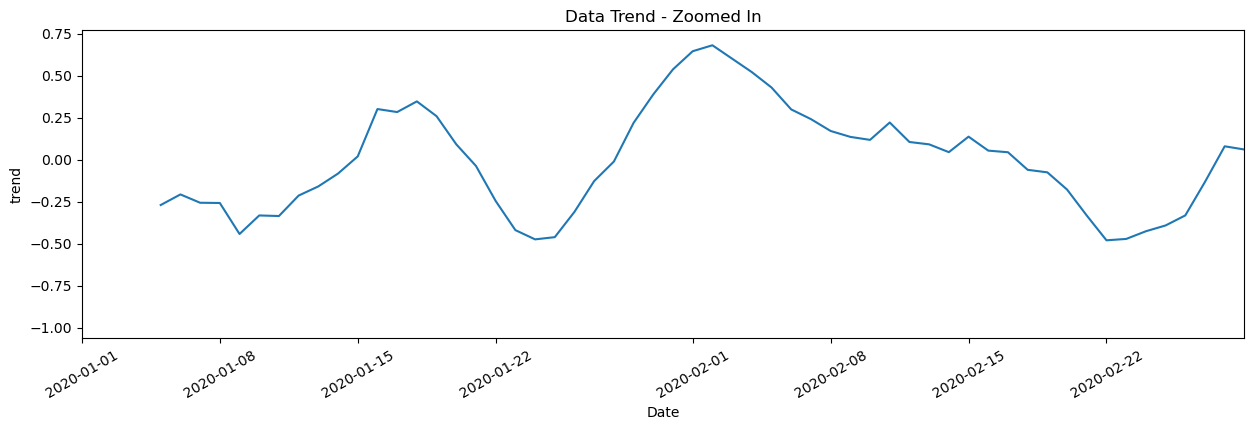

In [15]:
#zooming in to graph
plt.figure(figsize=(15,4))
sns.lineplot(data=df_decomp.trend)
plt.title('Data Trend - Zoomed In')
plt.xticks(rotation=30)
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-29'))
plt.show

##### Auto Correlation and Partial Auto Correlation Functions

I used `plot_acf` and `plot_pacf` from `statsmodels.graphics.tsaplots`.  I used code from James Fulton to plot both graphs in the same line.  I used 24 lags for the 24 months in the data set, and I removed the 0 from the x-axis since 0 lags always equals 1.  From Dr. Elleh's PowerPoint presentation on slide 29, any points in the shaded blue area are insignificant and can be ignored.  From the ACF graph, the points tail off after two lags, and the PACF graph cuts off after one lag.  From Fulton's PowerPoint slide 7, a model where ACF tails off and PACF cuts off after lag p has an AR(p) model.  Putting it together, since PACF cuts off after one lags, this is an AR(1) model, and the p,d,q values would be (1,0,0).

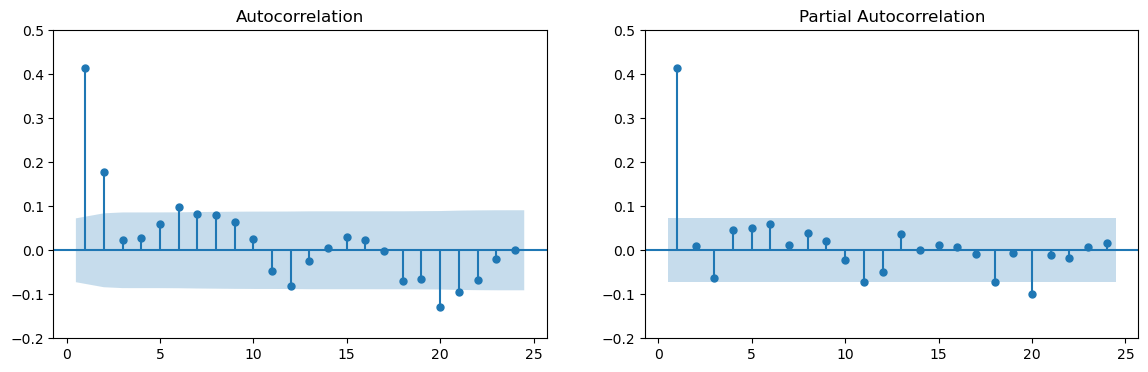

In [16]:
#creating plots display
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

#creating ACF plot
plt.subplot(121)
plot_acf(df_diff, lags=24, zero=False, ax=ax1)
plt.ylim(-.2, .5)

#creating PACF plot
plt.subplot(122)
plot_pacf(df_diff, lags=24, method='ywm', zero=False, ax=ax2)
plt.ylim(-.2, .5)

plt.show()

##### Spectral Density

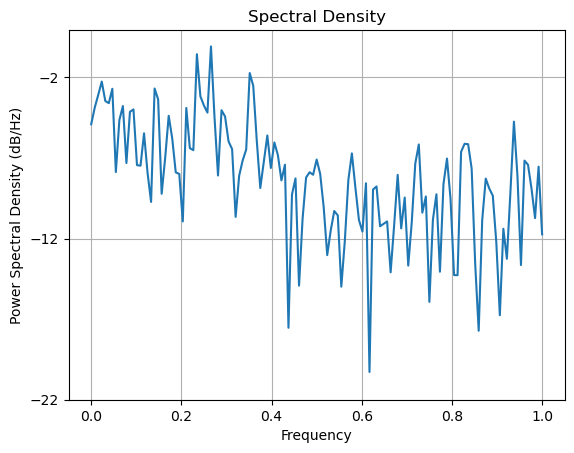

In [17]:
#creating spectral density graph
plt.psd(df_diff['Revenue'])
plt.title('Spectral Density')
plt.show()

##### Decomposed Time Series

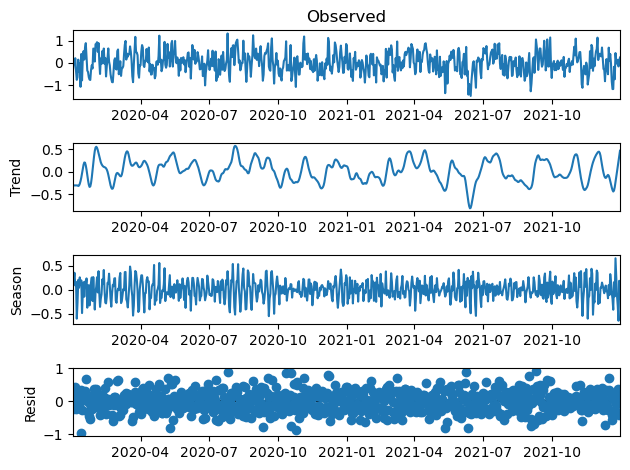

In [18]:
#showing decomposed graphs using STL
stl = STL(df_diff)
res = stl.fit()
res.plot()
plt.show()

##### Residuals of the Decomposed Series

Per Dr. Elleh's PowerPoint on slide 36, the residual values are left once seasonality, and trends are removed from the data.  No noticeable trends are observed in both the full graph and the zoomed in graph.

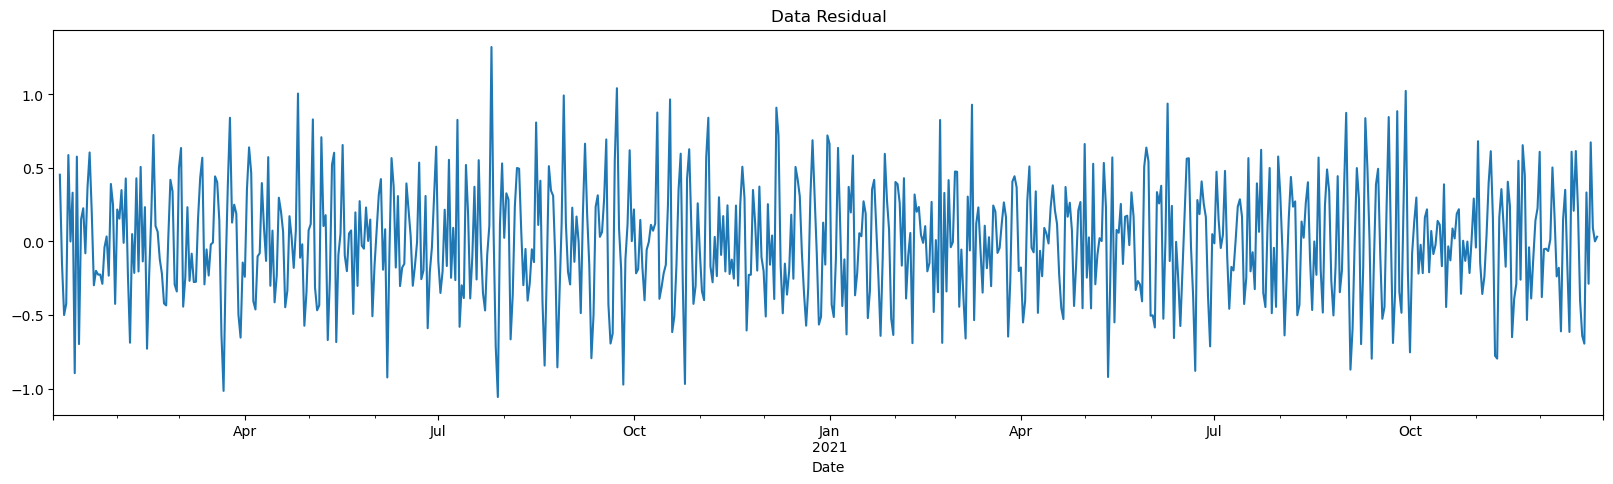

In [19]:
#plotting residual graph
plt.figure(figsize=(20,5))
df_decomp.resid.plot()
plt.title('Data Residual')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

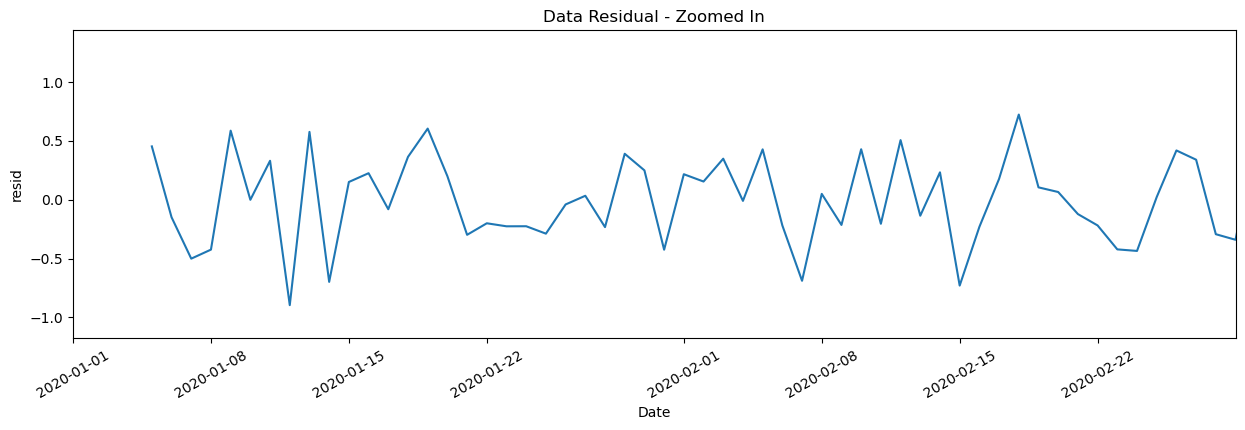

In [20]:
#zooming in to graph
plt.figure(figsize=(15,4))
sns.lineplot(data=df_decomp.resid)
plt.title('Data Residual - Zoomed In')
plt.xticks(rotation=30)
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-02-29'))
plt.show

#### D2. ARIMA Model<a id='d2'></a>

I first ran the `auto_arima`, which produced three sets of parentheses: (1,0,0)(0,0,0)[0].   The first set tells me the p,d, and q values for the model, the second set confirms that there's no seasonality, and the last set confirms that no differencing is needed.  Both the stepwise and ARIMA methods provide the same pdq values of 1, 0, 0, respectively.



In [21]:
#running auto-ARIMA
step = auto_arima(df_diff, trace=True)
print(step.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1015.481, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=879.982, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=881.911, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=881.927, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=905.166, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=881.947, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.966 seconds
                               SA

In [22]:
#applying ARIMA to training set
model = ARIMA(train, order=(1,0,0), freq='D')
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Mon, 21 Aug 2023   AIC                            706.698
Time:                        08:53:26   BIC                            719.808
Sample:                    01-02-2020   HQIC                           711.808
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

C:\Users\Favio\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### D3. Forecasting Using ARIMA Model<a id='d3'></a>

To graph the forecast, I started off by predicting using ARIMA by applying `.predict()` to the `results_ARIMA`.  At this step, I created two separate prediction variables:

<ul>
    <li>`prediction` to use the dates coinciding with the test set</li>
    <li>`prediction2` to extend predictions to 2022-06-30, so I can later apply `cumsum()` and predict beyond the data</li>
</ul>

The `Test Revenue` values from the `Daily Revenue Prediction and Mean Revenue` graph surround, the `Mean Revenue` line, which are on 0 and it's exactly what I want to see to confirm stationarity.

The next several steps where performed to prepare to forecast the data:

<ul>
    <li>Converted prediction2 to a dataframe type</li>
    <li>Combined train` set to prediction2 into df_joined, and applied .cumsum()</li>
    <li>From df_joined extracted data using start date of 2021-08-08 (which is when the test set starts)</li>
    <li>Calculated confidence intervals extending to 2022-06-30</li>
    <li>In order to apply cumulative sum to the confidence intervals (CI), I added the revenue value from before the CI starting value (so, from 2021-08-07)</li>
</ul>

After performing the steps above, I had the information needed to plot the forecast data.  Lastly, I calculated RMSE comparing the original data values to the predicted values for daily revenues between 2021-08-08 and 2021-12-31, and I graphed the diagnostic plots.  The RMSE tells us how close the predicted values are to the observed values (Grace-Martin, n.d.).

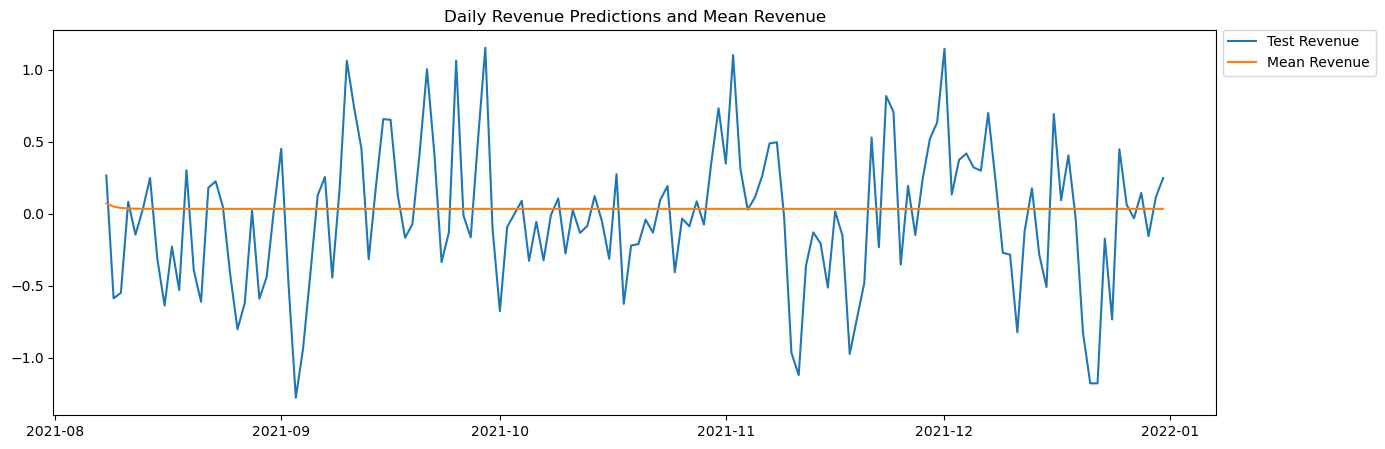

In [23]:
#making predictions
start=len(train)
end=len(train) + len(test) - 1
prediction = results_ARIMA.predict(start=start, end=end, typ='levels')
#prepping to predict in the future
prediction2 = results_ARIMA.predict(start=start, end=end+181, typ='levels')

#plotting predictions
plt.figure(figsize=(15,5))
plt.plot(test, label='Test Revenue')
plt.plot(prediction, label='Mean Revenue')
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.title('Daily Revenue Predictions and Mean Revenue')
plt.show()

In [24]:
#converting prediction output to dataframe format to combine with training set
df_pred = pd.DataFrame(prediction2)
#renaming 'predicted_mean' to 'Revenue' to match training data set
df_pred.rename(columns={'predicted_mean': 'Revenue'}, inplace=True)

#joining df_pred to training set
df_joined = pd.concat([train, df_pred])

#converting data points to cumulative sum
df_joined = df_joined.cumsum()
df_joined

,Revenue
2020-01-02,-0.292356
2020-01-03,-0.327772
2020-01-04,-0.339987
2020-01-05,-0.124888
2020-01-06,-0.491590
...,...
2022-06-26,29.968826
2022-06-27,30.001617
2022-06-28,30.034407
2022-06-29,30.067198


In [25]:
#extracting predicted information only, starting from 2021-08-08
pred = df_joined.iloc[start:end+182]

#creating forecast and confidence intervals
diff_forecast = results_ARIMA.get_forecast(steps=327) #147 in test plus 180 days, or roughly 6 months
confidence_intervals = diff_forecast.conf_int()
#lower_limits = confidence_intervals.loc[:, 'lower Revenue']
#upper_limits = confidence_intervals.loc[:, 'upper Revenue']

#checking confidence intervals
confidence_intervals

,lower Revenue,upper Revenue
2021-08-08,-0.792856,0.934998
2021-08-09,-0.884621,0.981430
2021-08-10,-0.904871,0.983190
2021-08-11,-0.910461,0.981237
2021-08-12,-0.912301,0.980001
...,...,...
2022-06-26,-0.913421,0.979002
2022-06-27,-0.913421,0.979002
2022-06-28,-0.913421,0.979002
2022-06-29,-0.913421,0.979002


In [26]:
df_joined[-328:-327]

,Revenue
2021-08-07,19.312734


In [27]:
#need to apply cumulative sum to limits, but need to add in the revenue from 2021-08-07 to adjust values properly

#checking revenue of 2021-08-07
display(df_joined[-328:-327])

#setting value equal to value
value = df_joined[-328:-327]

,Revenue
2021-08-07,19.312734


In [28]:
#creating dataframe from 2021-08-07 revenue value
new_row = pd.DataFrame({'Date':value.index, 'lower Revenue': value.iloc[0], 
                        'upper Revenue': value.iloc[0]})
new_row.set_index('Date', inplace=True)

#checking to make sure row looks accurate
new_row

,lower Revenue,upper Revenue
Date,,
2021-08-07,19.312734,19.312734


In [29]:
#adding 2021-08-07 to confidence_interval dataframe
new_limits = pd.concat([new_row, confidence_intervals])
new_limits

,lower Revenue,upper Revenue
2021-08-07,19.312734,19.312734
2021-08-08,-0.792856,0.934998
2021-08-09,-0.884621,0.981430
2021-08-10,-0.904871,0.983190
2021-08-11,-0.910461,0.981237
...,...,...
2022-06-26,-0.913421,0.979002
2022-06-27,-0.913421,0.979002
2022-06-28,-0.913421,0.979002
2022-06-29,-0.913421,0.979002


In [30]:
#applying cumulative sum to confidence_intervals and dropping 2021-08-07
new_limits = new_limits.cumsum()[1:]
new_limits

,lower Revenue,upper Revenue
2021-08-08,18.519878,20.247732
2021-08-09,17.635257,21.229163
2021-08-10,16.730386,22.212353
2021-08-11,15.819925,23.193590
2021-08-12,14.907624,24.173592
...,...,...
2022-06-26,-275.559395,335.497046
2022-06-27,-276.472816,336.476049
2022-06-28,-277.386236,337.455051
2022-06-29,-278.299657,338.434053


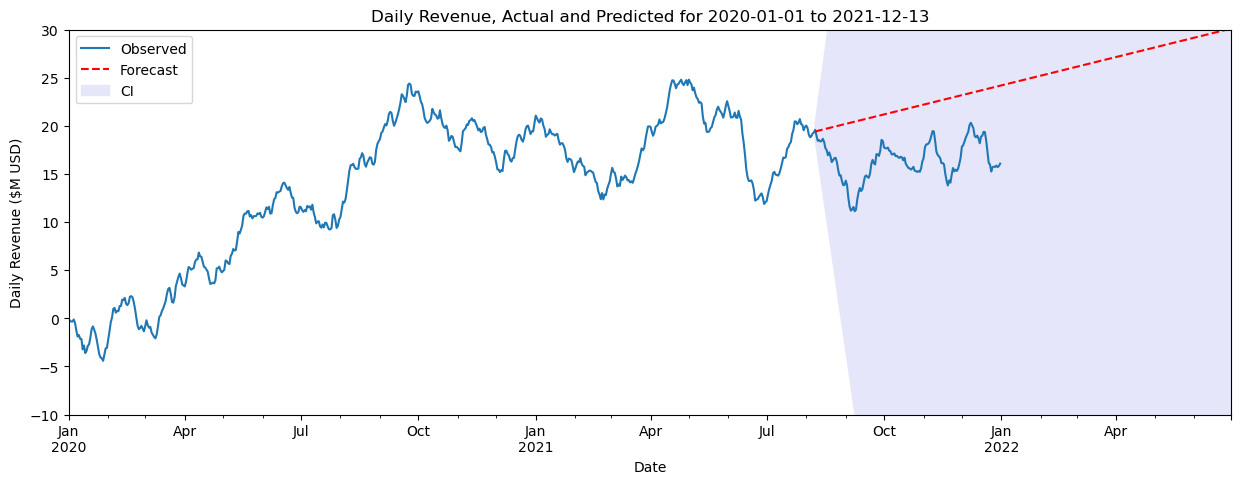

In [31]:
#creating forecasting graph with confidence intervals through 2022-06-30
plt.figure(figsize=(15,5))
df.Revenue.plot(label='Observed')
pred.Revenue.plot(color='red', linestyle='--', label='Forecast')
plt.fill_between(new_limits.index, new_limits['lower Revenue'], new_limits['upper Revenue'], color='lavender', label='CI')
plt.ylim(-10,30)
plt.xlim(['2020-01-01', '2022-06-30'])
plt.title('Daily Revenue, Actual and Predicted for 2020-01-01 to 2021-12-13')
plt.ylabel('Daily Revenue ($M USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [32]:
#calculating RMSE
rmse = sqrt(mean_squared_error(df.loc['2021-08-08':'2021-12-31'], pred.loc['2021-08-08':'2021-12-31']))
print('The RMSE value is : {:.2f}'.format(rmse))

The RMSE value is : 5.76


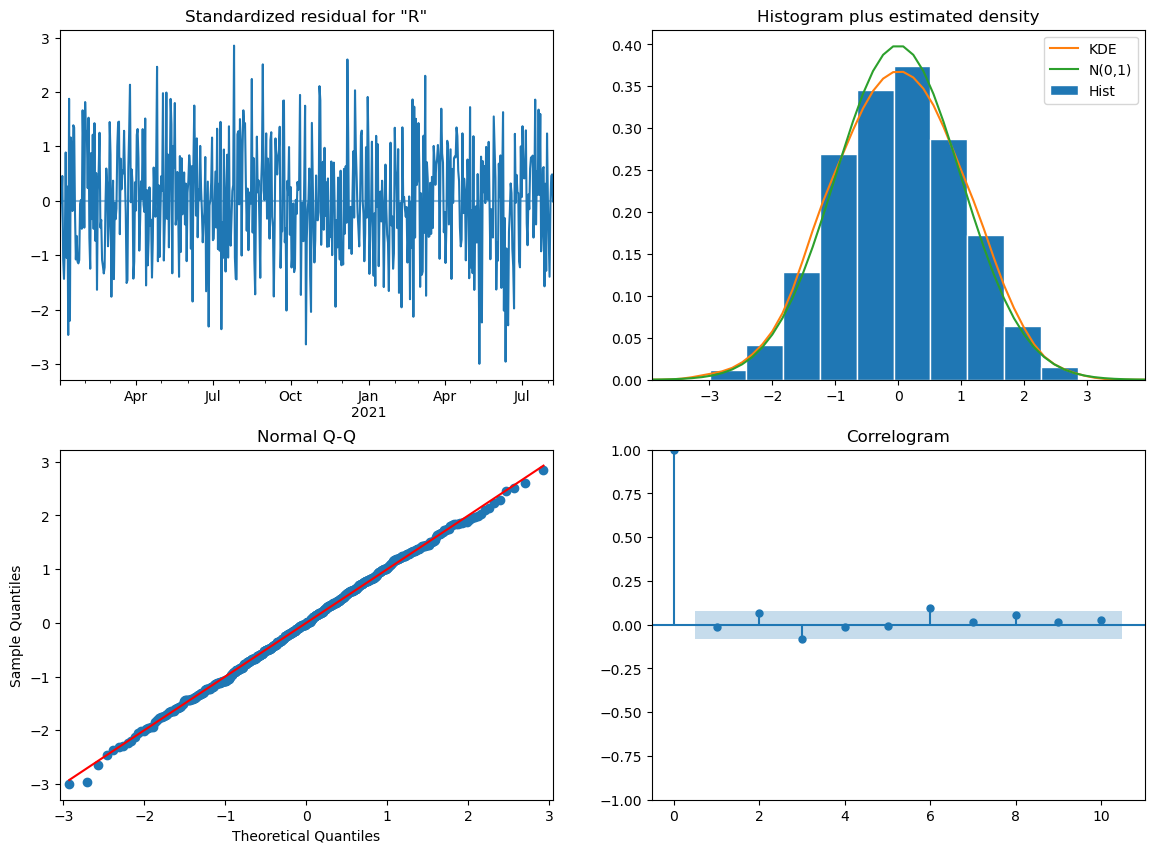

In [33]:
#using .plot_diagnostics to evaluate model
results_ARIMA.plot_diagnostics(figsize=(14,10))
plt.show()

#### D4. Output and Calculations<a id='d4'></a>

The code can be found through the document.

#### D5. Code<a id='d5'></a>

The code can be found through the document.

### PART V: DATA SUMMARY AND IMPLICATIONS

#### E1. Results<a id='e1'></a>

To select my ARIMA model, I plotted the ACF and PACF graphs, and I used `auto_arima` function from `pmdarima`.  From Dr. Elleh's PowerPoint presentation on slide 29, any points in the shaded blue area are insignificant and can be ignored. From the ACF graph, the points tail off after two lags and the PACF graph cuts off after one lag. From Fulton's PowerPoint slide 7, a model where ACF tails off and PACF cuts off after lag p has an AR(p) model. Since PACF cuts off after one lag, this is an AR(1) model, and the p,d,q values would be (1,0,0).  The auto ARIMA results confirmed the p,d,q values from my observations in the graphs.  The equation for the ARIMA model is Y<sub>t</sub> = 0.1943 + 0.4079(Y<sub>(t-1)</sub>).

For my confidence interval (CI), I set the start date as the beginning of the test set, so 2021-08-08.  I am extending my forecast through 2022-06-30, so my CI parameters have steps set at 327, which results in an end date of 2022-06-30.

Based on the predicted dashed line, the forecast is significant revenue growth.  The forecast is inconsistent with the observed data.  The data dictionary tells us the data is for the first two years of operations. Therefore, it's feasible that the hospital's realized losses at the beginning as they incurred business startup costs.  The daily revenues have been positive starting around April 2020.  The overall trend of the daily revenues is upward-trending and may be the culprit to the forecasted line increase.  Significant daily revenues dropped around August 2020, July 2021, and September 2021.  The CI covers the entire visible y-range in the graph, so the CI isn't effective at narrowing in.  Both the observed and forecasted values are well within the CI, but that's because the range of the CI is immense.

I calculated the root-mean-squared error (RMSE) to evaluate the predicted values' accuracy.  The calculation involved comparing observed and forecasted values, so the date range is from 2021-08-08 through 2021-12-31.  The RMSE calculation result was 5.76.

I also used `.plot_diagnostics()` to access the information.  The residual graph has no apparent trend and oscillates between ~-2.5 and ~3.  The histogram chart shows that most values are around 0, and the Q-Q plot shows the points mainly along the 45-degree line, which is the ideal result.  The last graph shows the correlation for different lags.  Points in the shaded blue area mean their correlation is insignificant.  The points at lag 3 and 6 are almost significant.

#### E2. Annotated Visualization<a id='e2'></a>

Based on the predicted dashed line, the forecast is significant revenue growth. The forecast is inconsistent with the observed data. The data dictionary tells us the data is for the first two years of operations. Therefore, it's feasible that the hospital's realized losses at the beginning as they incurred business startup costs. The daily revenues have been positive starting around April 2020. The overall trend of the daily revenues is upward-trending and may be the culprit to the forecasted line increase. Significant daily revenues dropped around August 2020, July 2021, and September 2021. The CI covers the entire visible y-range in the graph, so the CI isn't effective at narrowing in. Both the observed and forecasted values are well within the CI, but that's because the range of the CI is immense.

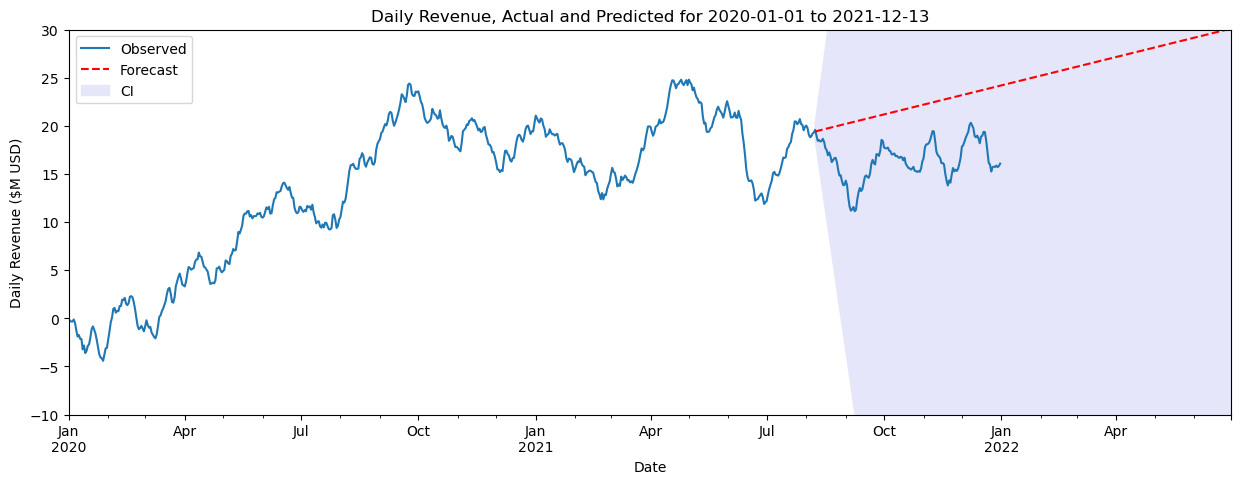

In [34]:
#creating forecasting graph with confidence intervals through 2022-06-30
plt.figure(figsize=(15,5))
df.Revenue.plot(label='Observed')
pred.Revenue.plot(color='red', linestyle='--', label='Forecast')
plt.fill_between(new_limits.index, new_limits['lower Revenue'], new_limits['upper Revenue'], color='lavender', label='CI')
plt.ylim(-10,30)
plt.xlim(['2020-01-01', '2022-06-30'])
plt.title('Daily Revenue, Actual and Predicted for 2020-01-01 to 2021-12-13')
plt.ylabel('Daily Revenue ($M USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### E3. Recommendation<a id='e3'></a>

The ARIMA model forecasted the daily revenues, to some degree, from 2021-08-08 to the end of the year.  However, as mentioned above, the confidence interval needs to be more effectively narrow in the values.  More research is required.  For example, a significant drop in revenue in mid-September does not align with the forecast, so the hospital should dig into the cause of the revenue drop in this timeframe.  Although not in the forecasted range, revenue significantly dropped in July 2021.  Due in part to the hospital startup costs, the daily revenues are impacted at the company's inception.  Another factor could be the purchase of costly equipment being depreciated over the first few years; this could be muting the revenue growth and forecasting into the future when depreciation expenses have changed.  Information is not provided on the specifics of revenue, and clarification is not provided on whether the data points to revenue or before any expenses.

### PART VI: REPORTING

#### F. Reporting<a id='f'></a>

A Jupyter Notebook will be submitted for the performance assessment.

#### G. Third-Party Code References<a id='g'></a>

Elleh, Dr. Festus (n.d.).  <i>Advanced Data Analytics - Task 1</i>.  [PowerPoint].
        </br>&emsp;&emsp;Western Governors University.
        
Fulton, James (n.d.).  <i>Intro to ACF and PACF</i>.  DataCamp.
        </br>&emsp;&emsp;Retrieved August 17, 2023, from https://s3.amazonaws.com/assets.datacamp.com/production/course_17329/slides/chapter3.pdf
        
matplotlib (n.d.).  <i>matplotlib.pyplot.fill_between</i>.  matplotlib.
    </br>&emsp;&emsp;Retrieved August 19, 2023, from https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html

Pandas (n.d.).  <i>Merge, join, concatenate and compare</i>.  Pandas.
    </br>&emsp;&emsp;Retrieved August 18, 2023, from https://pandas.pydata.org/docs/user_guide/merging.html

Sewell, Dr. William (n.d.).  <i>D213 Advanced Data Analytics ARIMA Modeling I</i>.  [Webinar].
        </br>&emsp;&emsp;Western Governors University.
        
Sewell, Dr. William (n.d.).  <i>D213 Time Series II ARIMA</i>.  [Video].
        </br>&emsp;&emsp;Western Governors University.  https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ca05f610-106a-497d-90a3-aed800fbba2f

#### H. Sources<a id='h'></a>

Grace-Martin, Karen (n.d.).  <i>measures of model fit for linear regression models</i>.  The Analysis Factor.
    </br>&emsp;&emsp;Retrieved August 15, 2023, from https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/#:~:text=prediction%20or%20explanation.-,RMSE,an%20absolute%20measure%20of%20fit.

Rajbhoj, Abhishek (2019, September 26).  <i>ARIMA simplified</i>.  Towards Data Science.
    </br>&emsp;&emsp;Retrieved August 15, 2023, from https://towardsdatascience.com/arima-simplified-b63315f27cbc

Wu, Songhao (2021, July 4).  <i>Stationarity Assumption in Time Series Data</i>.  Towards Data Science.
    </br>&emsp;&emsp;Retrieved August 15, 2023, from https://towardsdatascience.com/stationarity-assumption-in-time-series-data-67ec93d0f2f